In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Preparing features and labels
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5,shift=1,drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [3]:
## Preparing features and labels
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [4]:
## Preparing features and labels
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window: (window[:-1],window[-1]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), end = " ")
  print(y.numpy())

[4 5 6 7] 8
[1 2 3 4] 5
[5 6 7 8] 9
[3 4 5 6] 7
[2 3 4 5] 6
[0 1 2 3] 4


In [5]:
## Preparing features and labels
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window: (window[:-1],window[-1]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [8 7]
x =  [[5 6 7 8]
 [0 1 2 3]]
y =  [9 4]
x =  [[2 3 4 5]
 [1 2 3 4]]
y =  [6 5]


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1,drop_remainder=True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
def plot_series(time, series, format="-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2 * np.pi), 
                  1/np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase) % period) / period
  return amplitude * seasonal_pattern(season_time) 

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time,0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
dataset = windowed_dataset(x_train,window_size, batch_size,shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

In [12]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.04031752],
       [-0.00463792],
       [ 0.03866632],
       [-0.0097454 ],
       [ 0.02412466],
       [ 0.00884319],
       [-0.01904005],
       [ 0.01389131],
       [-0.01814935],
       [ 0.0303656 ],
       [-0.01401292],
       [ 0.00438699],
       [-0.04460168],
       [ 0.04853401],
       [ 0.01646345],
       [ 0.06319667],
       [ 0.01458623],
       [ 0.16289936],
       [ 0.26664382],
       [ 0.46255478]], dtype=float32), array([0.04177047], dtype=float32)]


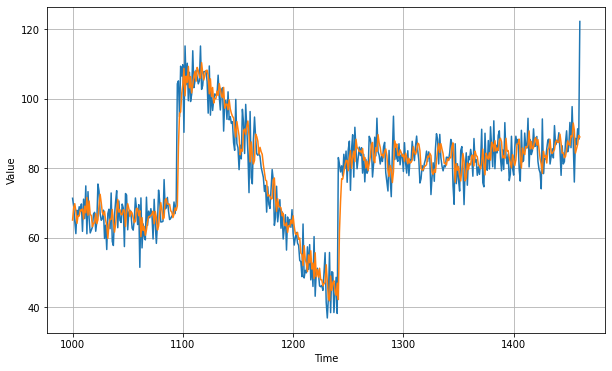

In [13]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9983215

In [44]:
## With DNN

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape=[window_size],activation = 'relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

In [45]:
model1.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9))
history = model1.fit(dataset, epochs=100,verbose=0)

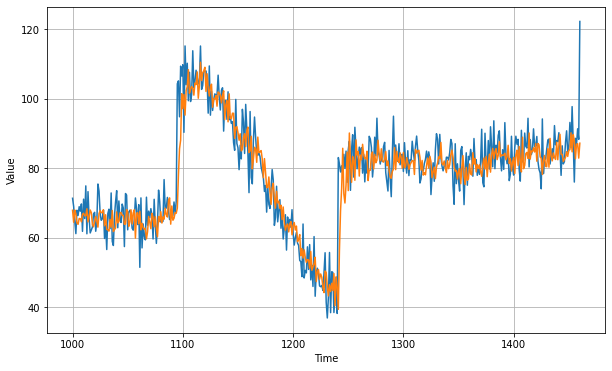

In [46]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model1.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [47]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0532928

In [24]:
## call back with lr scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.9)

model1.compile(loss='mse',optimizer=optimizer)
history = model1.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose = 0) 

(1e-08, 0.001, 0.0, 300.0)

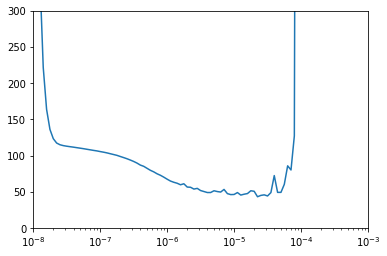

In [25]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))

plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [38]:
## from the above graph, loss is lowest at around 8 * 1e-6 . So, we will use that learning rate to train the model

window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape=[window_size],activation = 'relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr = 7e-6, momentum = 0.9)

model2.compile(loss='mse',optimizer=optimizer)
history = model2.fit(dataset, epochs=500, verbose = 0) 

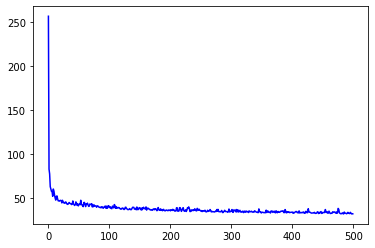

In [39]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.show()

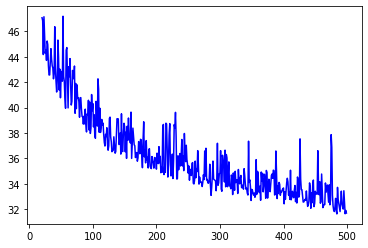

In [43]:
## plot all but first 100
loss = history.history['loss']
epochs = range(20,len(loss))
plot_loss = loss[20:]
plt.plot(epochs, plot_loss, 'b', label='Training loss')
plt.show()

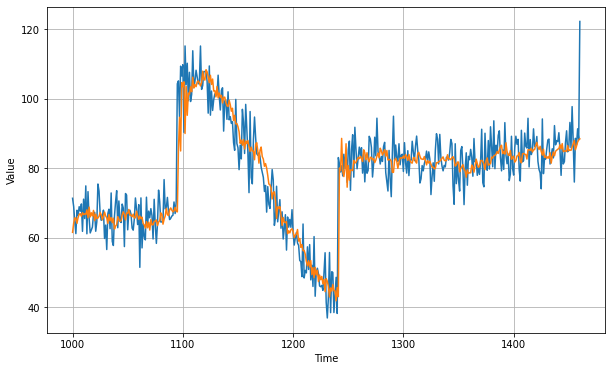

In [41]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model2.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [42]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6510615